# All combinations for all models (All CPU THREADS)

In [ ]:
import os
import tensorflow as tf
from datamodule import datamodule
from transformer import Transformer
from lstm import LSTM
from FFNN import FFNN
from xgboost import XGBRegressor 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import concurrent.futures
import threading

# Set CPU thread management
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['TF_NUM_INTEROP_THREADS'] = '4'
os.environ['TF_NUM_INTRAOP_THREADS'] = '4'

# TensorFlow config for thread management
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.threading.set_intra_op_parallelism_threads(4)

# Function to calculate evaluation metrics
def eval_metrics(y_true, y_pred):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    return r2, mae, mse

# Initialize storage for results
model_results = {model: {'r2': 0, 'mae': 0, 'mse': 0, 'count': 0} for model in 
                 ['HistGradientBoostingRegressor', 'DecisionTreeRegressor', 'XGBRegressor', 'FFNN', 'LSTM', 'Transformer', 'SVR']}

crops = [datamodule.HOSTVETE, datamodule.VARKORN, datamodule.RAGVETE]
pests = {datamodule.HOSTVETE: ['Bladfläcksvampar', 'Brunrost', 'Svartpricksjuka','Gulrost', 'Mjöldagg'],
         datamodule.VARKORN: ['Sköldfläcksjuka', 'Kornets bladfläcksjuka', 'Mjöldagg', 'Havrebladlus', 'Sädesbladlus'],
         datamodule.RAGVETE: ['Brunrost', 'Gulrost', 'Sköldfläcksjuka', 'Mjöldagg', 'Bladfläcksvampar']}

def process_crop_pest(crop, pest):
    global model_results
    lock = threading.Lock()
    
    # Load data
    dm = datamodule(crop)
    dm.default_process(target=pest)
    splits = dm.CV_test_train_split(n_folds=10)
    
    # Store predictions and actuals
    actuals = []
    predictions = {model: [] for model in model_results.keys()}

    for X_train, X_test, y_train, y_test in splits:
        timesteps, features = 1, X_train.shape[1]
        X_train_lstm = np.array(X_train).reshape(-1, timesteps, features)
        X_test_lstm = np.array(X_test).reshape(-1, timesteps, features)

        # Initialize models
        models = {
            'FFNN': FFNN(input_shape=X_train.shape[1]),
            'SVR': SVR(kernel='rbf', C=10, gamma='auto', epsilon=0.01),
            'Transformer': Transformer(features=features),
            'LSTM': LSTM(features=features, timesteps=timesteps),
            'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
            'DecisionTreeRegressor': DecisionTreeRegressor(),
            'XGBRegressor': XGBRegressor(n_jobs=4)
        }
        
        # Train models
        for model_name, model in models.items():
            if model_name == 'LSTM':
                model.fit(X_train_lstm, y_train)
            else:
                model.fit(X_train, y_train.squeeze())
        
        # Make predictions
        for model_name, model in models.items():
            if model_name == 'LSTM':
                y_pred = model.predict(X_test_lstm)
            else:
                y_pred = model.predict(X_test)
            
            predictions[model_name].append(pd.DataFrame(y_pred, index=X_test.index))
            
        actuals.append(y_test)
    
    # Aggregate results
    actuals = pd.concat(actuals)
    actuals = dm.inverse_scale(actuals)
    
    for model_name in model_results.keys():
        pred = pd.concat(predictions[model_name])
        pred = dm.inverse_scale(pred)
        r2, mae, mse = eval_metrics(actuals, pred)
        
        model_results[model_name]['r2'] += r2
        model_results[model_name]['mae'] += mae
        model_results[model_name]['mse'] += mse
        model_results[model_name]['count'] += 1

# Compute average metrics
average_metrics = {model: {
    'avg_r2': model_results[model]['r2'] / model_results[model]['count'],
    'avg_mae': model_results[model]['mae'] / model_results[model]['count'],
    'avg_mse': model_results[model]['mse'] / model_results[model]['count'],
} for model in model_results if model_results[model]['count'] > 0}

# Print final results
for model, metrics in average_metrics.items():
    print(f"Model: {model} | Avg R²: {metrics['avg_r2']:.4f} | Avg MAE: {metrics['avg_mae']:.4f} | Avg MSE: {metrics['avg_mse']:.4f}")


Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12
Epoch 1/12


KeyboardInterrupt: 

# All Combinations for the Best Performing Model

In [ ]:
from datamodule import datamodule

from transformer import Transformer
from lstm import LSTM
from FFNN import FFNN
from xgboost import XGBRegressor 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns

def eval_metrics(y_true, y_pred):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    return (r2, mae, mse)

crops = [datamodule.HOSTVETE, datamodule.VARKORN, datamodule.RAGVETE]
pests = {datamodule.HOSTVETE: ['Bladfläcksvampar', 'Brunrost', 'Svartpricksjuka','Gulrost', 'Mjöldagg'],
         datamodule.VARKORN: ['Sköldfläcksjuka', 'Kornets bladfläcksjuka', 'Mjöldagg', 'Havrebladlus', 'Sädesbladlus'],
         datamodule.RAGVETE: ['Brunrost', 'Gulrost', 'Sköldfläcksjuka', 'Mjöldagg', 'Bladfläcksvampar']}

crop_results = {}
for crop in crops:
    pest_results = {}
    for pest in pests[crop]:
        # GET DATA
        dm = datamodule(crop)
        dm.default_process(target=pest)

        splits = dm.CV_test_train_split(n_folds=10)

        # ACTUALS AND PREDICTIONS
        actuals = []
        predictions = []

        # RUN TESTS
        current_split = 1
        for X_train, X_test, y_train, y_test in splits:
            print(f"----------------------------- split {current_split}/{len(splits)} -----------------------------")
            current_split += 1

            # timesteps = 1
            # features = X_train.shape[1]
            # X_train_lstm = np.array(X_train).reshape(-1, timesteps, features)
            # X_test_lstm = np.array(X_test).reshape(-1, timesteps, features)

            # get model
            model = HistGradientBoostingRegressor()
            
            # fit model
            model.fit(X_train, y_train.squeeze())
        
            # predict
            y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index)
        
            # inverse normalizaiton
            y_test = dm.inverse_scale(y_test)
            y_pred = dm.inverse_scale(y_pred)
        
            # save actuals and predictions
            actuals.append(y_test)
            predictions.append(y_pred)

        # GET EVALUTION METRIC RESULTS
        actuals = pd.concat(actuals)

        predictions = pd.concat(predictions)
        r2, mae, mse = eval_metrics(actuals, predictions)

        pest_results[pest] = (r2, mae, mse)
    
    crop_results[crop] = pest_results

# (r2, mae, mse) = crop_results[crop][pest]

Possible targets ['Bladfläcksvampar', 'Brunrost', 'Svartpricksjuka', 'Gulrost', 'Mjöldagg', 'Vetets bladfläcksjuka', 'Gräsbladlus', 'Sädesbladlus', 'Havrebladlus', 'Nederbörd']
----------------------------- split 1/10 -----------------------------
----------------------------- split 2/10 -----------------------------
----------------------------- split 3/10 -----------------------------
----------------------------- split 4/10 -----------------------------
----------------------------- split 5/10 -----------------------------
----------------------------- split 6/10 -----------------------------
----------------------------- split 7/10 -----------------------------
----------------------------- split 8/10 -----------------------------
----------------------------- split 9/10 -----------------------------
----------------------------- split 10/10 -----------------------------
Possible targets ['Bladfläcksvampar', 'Brunrost', 'Svartpricksjuka', 'Gulrost', 'Mjöldagg', 'Vetets bladfläcksju

In [56]:
results = []

for crop, pest_results in crop_results.items():
    for pest, metrics in pest_results.items():
        if metrics is not None:
            r_squared, mae, mse = metrics
            results.append({
                'Crop': crop,
                'Pest': pest,
                'R²': r_squared,
                'MAE': mae,
                'MSE': mse
            })

results_df = pd.DataFrame(results)
results_df.to_csv('crop_results.csv', index=False)

In [59]:
latex_table = r"""\begin{table}[htbp]
    \caption{Performance Metrics for Different Crops}
    \centering
    \begin{tabular}{|l|l|c|c|c|}
        \hline
        \textbf{Crop} & \textbf{Disease} & \textbf{R²} & \textbf{MAE} & \textbf{MSE} \\
        \hline
"""

for crop, group in results_df.groupby('Crop'):
    latex_table += f"        \\multirow{{{len(group)}}}{{*}}{{{crop}}}  \n"
    for index, row in group.iterrows():
        if index == group.index[0]:  
            latex_table += f"        & {row['Pest']} & {row['R²']:.2f} & {row['MAE']:.2f} & {row['MSE']:.2f} \\\\\n"
        else: 
            latex_table += f"        & {row['Pest']} & {row['R²']:.2f} & {row['MAE']:.2f} & {row['MSE']:.2f} \\\\\n"
    latex_table += "        \\hline\n"

latex_table += r"""    \end{tabular}
    \label{tab:crop_metrics}
\end{table}"""

print(latex_table)

\begin{table}[htbp]
    \caption{Performance Metrics for Different Crops}
    \centering
    \begin{tabular}{|l|l|c|c|c|}
        \hline
        \textbf{Crop} & \textbf{Disease} & \textbf{R²} & \textbf{MAE} & \textbf{MSE} \\
        \hline
        \multirow{5}{*}{Hostvete}  
        & Bladfläcksvampar & 0.83 & 5.67 & 87.52 \\
        & Brunrost & 0.77 & 0.80 & 14.40 \\
        & Svartpricksjuka & 0.85 & 4.37 & 58.71 \\
        & Gulrost & 0.88 & 0.89 & 11.79 \\
        & Mjöldagg & 0.84 & 2.56 & 38.45 \\
        \hline
        \multirow{5}{*}{Ragvete}  
        & Brunrost & 0.35 & 1.01 & 18.76 \\
        & Gulrost & 0.88 & 2.66 & 37.87 \\
        & Sköldfläcksjuka & 0.52 & 1.41 & 13.97 \\
        & Mjöldagg & 0.80 & 7.41 & 130.43 \\
        & Bladfläcksvampar & 0.51 & 2.66 & 36.86 \\
        \hline
        \multirow{5}{*}{Varkorn}  
        & Sköldfläcksjuka & 0.60 & 0.55 & 4.81 \\
        & Kornets bladfläcksjuka & 0.80 & 2.84 & 45.49 \\
        & Mjöldagg & 0.78 & 0.76 & 11.01 \\
   

# One Combination

In [6]:
from datamodule import datamodule

from transformer import Transformer
from lstm import LSTM
from FFNN import FFNN
from xgboost import XGBRegressor 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns

def eval_metrics(y_true, y_pred):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    return (r2, mae, mse)

# GET DATA
dm = datamodule(datamodule.HOSTVETE)
dm.default_process(target='Svartpricksjuka')

splits = dm.CV_test_train_split(n_folds=10)

# ACTUALS AND PREDICTIONS
actuals = []

predictions_Transformer = []
predictions_LSTM = [] 
predictions_FFNN = [] 
predictions_HistGradientBoostingRegressor = []
predictions_XGBRegressor = [] 
predictions_DecisionTreeRegressor = [] 
predictions_SVR = [] 

# RUN TESTS
current_split = 1
for X_train, X_test, y_train, y_test in splits:
    print(f"----------------------------- split {current_split}/{len(splits)} -----------------------------")
    current_split += 1

    timesteps = 1
    features = X_train.shape[1]
    X_train_lstm = np.array(X_train).reshape(-1, timesteps, features)
    X_test_lstm = np.array(X_test).reshape(-1, timesteps, features)

    # get model
    model_FFNN = FFNN(input_shape=X_train.shape[1])
    model_SVR = SVR(kernel='rbf', C=10, gamma='auto', epsilon=0.01)
    model_Transformer = Transformer(features=features)
    model_LSTM = LSTM(features=features, timesteps=timesteps)
    model_HistGradientBoostingRegressor = HistGradientBoostingRegressor()
    model_DecisionTreeRegressor = DecisionTreeRegressor()
    model_predictions_XGBRegressor = XGBRegressor()
    
    # fit model
    model_FFNN.fit(X_train, y_train)
    model_SVR.fit(X_train, y_train.squeeze())
    model_Transformer.fit(X_train, y_train)
    model_HistGradientBoostingRegressor.fit(X_train, y_train.squeeze())
    model_DecisionTreeRegressor.fit(X_train, y_train.squeeze())
    model_predictions_XGBRegressor.fit(X_train, y_train.squeeze())
    model_LSTM.fit(X_train_lstm, y_train)
 
    # predict
    y_pred_SVR = pd.DataFrame(model_SVR.predict(X_test), index=X_test.index)
    y_pred_HistGradientBoostingRegressor = pd.DataFrame(model_HistGradientBoostingRegressor.predict(X_test), index=X_test.index)
    y_pred_DecisionTreeRegressor = pd.DataFrame(model_DecisionTreeRegressor.predict(X_test), index=X_test.index)
    y_pred_XGBRegressor = pd.DataFrame(model_predictions_XGBRegressor.predict(X_test), index=X_test.index)
    y_pred_LSTM = pd.DataFrame(model_LSTM.predict(X_test_lstm), index=X_test.index)
    y_pred_Transformer = pd.DataFrame(model_Transformer.predict(X_test), index=X_test.index)
    y_pred_FFNN = pd.DataFrame(model_FFNN.predict(X_test), index=X_test.index)
 
    # inverse normalizaiton
    y_pred_FFNN = dm.inverse_scale(y_pred_FFNN)
    y_test = dm.inverse_scale(y_test)
    y_pred_HistGradientBoostingRegressor = dm.inverse_scale(y_pred_HistGradientBoostingRegressor)
    y_pred_DecisionTreeRegressor = dm.inverse_scale(y_pred_DecisionTreeRegressor)
    y_pred_XGBRegressor = dm.inverse_scale(y_pred_XGBRegressor)
    y_pred_LSTM = dm.inverse_scale(y_pred_LSTM)
    y_pred_Transformer = dm.inverse_scale(y_pred_Transformer)
    y_pred_SVR = dm.inverse_scale(y_pred_SVR)
 
    # save actuals and predictions
    predictions_FFNN.append(y_pred_FFNN)
    actuals.append(y_test)
    predictions_HistGradientBoostingRegressor.append(y_pred_HistGradientBoostingRegressor)
    predictions_DecisionTreeRegressor.append(y_pred_DecisionTreeRegressor)
    predictions_XGBRegressor.append(y_pred_XGBRegressor)
    predictions_LSTM.append(y_pred_LSTM)
    predictions_Transformer.append(y_pred_Transformer)
    predictions_SVR.append(y_pred_SVR)

# GET EVALUTION METRIC RESULTS
actuals = pd.concat(actuals)

predictions_FFNN = pd.concat(predictions_FFNN)
r2_FFNN, mae_FFNN, mse_FFNN = eval_metrics(actuals, predictions_FFNN)

predictions_HistGradientBoostingRegressor = pd.concat(predictions_HistGradientBoostingRegressor)
r2_HistGradientBoostingRegressor, mae_HistGradientBoostingRegressor, mse_HistGradientBoostingRegressor = eval_metrics(actuals, predictions_HistGradientBoostingRegressor)

predictions_DecisionTreeRegressor = pd.concat(predictions_DecisionTreeRegressor)
r2_DecisionTreeRegressor, mae_DecisionTreeRegressor, mse_DecisionTreeRegressor = eval_metrics(actuals, predictions_DecisionTreeRegressor)

predictions_XGBRegressor = pd.concat(predictions_XGBRegressor)
r2_XGBRegressor, mae_XGBRegressor, mse_XGBRegressor = eval_metrics(actuals, predictions_XGBRegressor)

predictions_LSTM = pd.concat(predictions_LSTM)
r2_LSTM, mae_LSTM, mse_LSTM = eval_metrics(actuals, predictions_LSTM)

predictions_Transformer = pd.concat(predictions_Transformer)
r2_Transformer, mae_Transformer, mse_Transformer = eval_metrics(actuals, predictions_Transformer)

predictions_SVR = pd.concat(predictions_SVR)
r2_SVR, mae_SVR, mse_SVR = eval_metrics(actuals, predictions_SVR)

# collect metric outputs
models = ['HistGradientBoostingRegressor', 'DecisionTreeRegressor', 'XGBRegressor', 'FFNN', 'LSTM', 'Transformer', 'SVR']
r2s = [r2_HistGradientBoostingRegressor, r2_DecisionTreeRegressor, r2_XGBRegressor, r2_FFNN, r2_LSTM, r2_Transformer, r2_SVR]
maes = [mae_HistGradientBoostingRegressor, mae_DecisionTreeRegressor, mae_XGBRegressor, mae_FFNN, mae_LSTM, mae_Transformer, mae_SVR]
mses = [mse_HistGradientBoostingRegressor, mse_DecisionTreeRegressor, mse_XGBRegressor, mse_FFNN, mse_LSTM, mse_Transformer, mse_SVR]

----------------------------- split 1/10 -----------------------------
Epoch 1/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1867 - mae: 0.5085 - val_loss: 0.0678 - val_mae: 0.3376
Epoch 2/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0826 - mae: 0.3290 - val_loss: 0.0326 - val_mae: 0.2127
Epoch 3/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0611 - mae: 0.2771 - val_loss: 0.0215 - val_mae: 0.1483
Epoch 4/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0465 - mae: 0.2408 - val_loss: 0.0257 - val_mae: 0.1889
Epoch 5/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0362 - mae: 0.2100 - val_loss: 0.0081 - val_mae: 0.0928
Epoch 6/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0277 - mae: 0.1828 - val_loss: 0.0086 - val_mae: 0.1028
Epoch 7/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0224 - mae: 0.1628 - val_loss: 0.0046 - val_mae: 0.0706
Epoch 8/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0183 - mae: 0.1463 - val_loss: 0.0053 -

# KÖR 1

In [ ]:
from datamodule import datamodule

from transformer import Transformer
from lstm import LSTM
# from FFNN import FFNN
from xgboost import XGBRegressor 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from jbv_models.model import FNNRegressor
from jbv_models.datamodule import JBVDataModule

import pytorch_lightning as pl

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns
import torch

def eval_metrics(y_true, y_pred):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    return (r2, mae, mse)

best_learning_rate = 0.00023492087942582194
best_weight_decay = 8.676935089930829e-06
best_dropout = 0.07468054507323517
best_activation = 'leaky_relu'
hidden_sizes_best = [192, 224]
loss_fn_name="huber"

# GET DATA
dm = datamodule(datamodule.HOSTVETE)
dm.default_process(target='Svartpricksjuka')

splits = dm.CV_test_train_split(n_folds=10)

# ACTUALS AND PREDICTIONS
actuals = []

predictions_Transformer = []
predictions_LSTM = [] 
predictions_FFNN = [] 
predictions_HistGradientBoostingRegressor = []
predictions_XGBRegressor = [] 
predictions_DecisionTreeRegressor = [] 
predictions_SVR = [] 

# RUN TESTS
current_split = 1
for X_train, X_test, y_train, y_test in splits:
    print(f"----------------------------- split {current_split}/{len(splits)} -----------------------------")
    current_split += 1

    timesteps = 1
    features = X_train.shape[1]
    X_train_lstm = np.array(X_train).reshape(-1, timesteps, features)
    X_test_lstm = np.array(X_test).reshape(-1, timesteps, features)
    data = JBVDataModule(X_train, y_train, X_test, y_test,batch_size=32,num_workers=11,val_size=0.2, random_state=42)

    # get model
    model_FFNN = FNNRegressor(
        input_size=X_train.shape[1],
        hidden_sizes=hidden_sizes_best,
        learning_rate=best_learning_rate,
        weight_decay=best_weight_decay,
        activation=best_activation,
        dropout=best_dropout,
        loss_fn_name=loss_fn_name
        )
    trainer = pl.Trainer(max_epochs=100, enable_checkpointing=False, accelerator="cpu", devices=1)
    model_SVR = SVR(kernel='rbf', C=10, gamma='auto', epsilon=0.01)
    model_Transformer = Transformer(features=features)
    model_LSTM = LSTM(features=features, timesteps=timesteps)
    model_HistGradientBoostingRegressor = HistGradientBoostingRegressor()
    model_DecisionTreeRegressor = DecisionTreeRegressor()
    model_predictions_XGBRegressor = XGBRegressor()
    
    # fit model
    trainer.fit(model_FFNN, data)
    model_SVR.fit(X_train, y_train.squeeze())
    model_Transformer.fit(X_train, y_train)
    model_HistGradientBoostingRegressor.fit(X_train, y_train.squeeze())
    model_DecisionTreeRegressor.fit(X_train, y_train.squeeze())
    model_predictions_XGBRegressor.fit(X_train, y_train.squeeze())
    model_LSTM.fit(X_train_lstm, y_train)
 
    # predict
    y_pred_SVR = pd.DataFrame(model_SVR.predict(X_test), index=X_test.index)
    y_pred_HistGradientBoostingRegressor = pd.DataFrame(model_HistGradientBoostingRegressor.predict(X_test), index=X_test.index)
    y_pred_DecisionTreeRegressor = pd.DataFrame(model_DecisionTreeRegressor.predict(X_test), index=X_test.index)
    y_pred_XGBRegressor = pd.DataFrame(model_predictions_XGBRegressor.predict(X_test), index=X_test.index)
    y_pred_LSTM = pd.DataFrame(model_LSTM.predict(X_test_lstm), index=X_test.index)
    y_pred_Transformer = pd.DataFrame(model_Transformer.predict(X_test), index=X_test.index)
    y_pred_FFNN = pd.DataFrame(torch.cat(trainer.predict(model_FFNN, data)).cpu().numpy(), index=X_test.index)
 
    # inverse normalizaiton
    y_pred_FFNN = dm.inverse_scale(y_pred_FFNN)
    y_test = dm.inverse_scale(y_test)
    y_pred_HistGradientBoostingRegressor = dm.inverse_scale(y_pred_HistGradientBoostingRegressor)
    y_pred_DecisionTreeRegressor = dm.inverse_scale(y_pred_DecisionTreeRegressor)
    y_pred_XGBRegressor = dm.inverse_scale(y_pred_XGBRegressor)
    y_pred_LSTM = dm.inverse_scale(y_pred_LSTM)
    y_pred_Transformer = dm.inverse_scale(y_pred_Transformer)
    y_pred_SVR = dm.inverse_scale(y_pred_SVR)
 
    # save actuals and predictions
    predictions_FFNN.append(y_pred_FFNN)
    actuals.append(y_test)
    predictions_HistGradientBoostingRegressor.append(y_pred_HistGradientBoostingRegressor)
    predictions_DecisionTreeRegressor.append(y_pred_DecisionTreeRegressor)
    predictions_XGBRegressor.append(y_pred_XGBRegressor)
    predictions_LSTM.append(y_pred_LSTM)
    predictions_Transformer.append(y_pred_Transformer)
    predictions_SVR.append(y_pred_SVR)

# GET EVALUTION METRIC RESULTS
actuals = pd.concat(actuals)

predictions_FFNN = pd.concat(predictions_FFNN)
r2_FFNN, mae_FFNN, mse_FFNN = eval_metrics(actuals, predictions_FFNN)

predictions_HistGradientBoostingRegressor = pd.concat(predictions_HistGradientBoostingRegressor)
r2_HistGradientBoostingRegressor, mae_HistGradientBoostingRegressor, mse_HistGradientBoostingRegressor = eval_metrics(actuals, predictions_HistGradientBoostingRegressor)

predictions_DecisionTreeRegressor = pd.concat(predictions_DecisionTreeRegressor)
r2_DecisionTreeRegressor, mae_DecisionTreeRegressor, mse_DecisionTreeRegressor = eval_metrics(actuals, predictions_DecisionTreeRegressor)

predictions_XGBRegressor = pd.concat(predictions_XGBRegressor)
r2_XGBRegressor, mae_XGBRegressor, mse_XGBRegressor = eval_metrics(actuals, predictions_XGBRegressor)

predictions_LSTM = pd.concat(predictions_LSTM)
r2_LSTM, mae_LSTM, mse_LSTM = eval_metrics(actuals, predictions_LSTM)

predictions_Transformer = pd.concat(predictions_Transformer)
r2_Transformer, mae_Transformer, mse_Transformer = eval_metrics(actuals, predictions_Transformer)

predictions_SVR = pd.concat(predictions_SVR)
r2_SVR, mae_SVR, mse_SVR = eval_metrics(actuals, predictions_SVR)

# collect metric outputs
models = ['HistGradientBoostingRegressor', 'DecisionTreeRegressor', 'XGBRegressor', 'FFNN', 'LSTM', 'Transformer', 'SVR']
r2s = [r2_HistGradientBoostingRegressor, r2_DecisionTreeRegressor, r2_XGBRegressor, r2_FFNN, r2_LSTM, r2_Transformer, r2_SVR]
maes = [mae_HistGradientBoostingRegressor, mae_DecisionTreeRegressor, mae_XGBRegressor, mae_FFNN, mae_LSTM, mae_Transformer, mae_SVR]
mses = [mse_HistGradientBoostingRegressor, mse_DecisionTreeRegressor, mse_XGBRegressor, mse_FFNN, mse_LSTM, mse_Transformer, mse_SVR]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


----------------------------- split 1/10 -----------------------------



   | Name      | Type              | Params | Mode 
---------------------------------------------------------
0  | model     | Sequential        | 46.9 K | train
1  | loss_fn   | HuberLoss         | 0      | train
2  | train_mae | MeanAbsoluteError | 0      | train
3  | train_mse | MeanSquaredError  | 0      | train
4  | train_r2  | R2Score           | 0      | train
5  | val_mae   | MeanAbsoluteError | 0      | train
6  | val_mse   | MeanSquaredError  | 0      | train
7  | val_r2    | R2Score           | 0      | train
8  | test_mae  | MeanAbsoluteError | 0      | train
9  | test_mse  | MeanSquaredError  | 0      | train
10 | test_r2   | R2Score           | 0      | train
---------------------------------------------------------
46.9 K    Trainable params
0         Non-trainable params
46.9 K    Total params
0.188     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Mahmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:624: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
C:\Users\Mahmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\Mahmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCa

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# KÖR 2

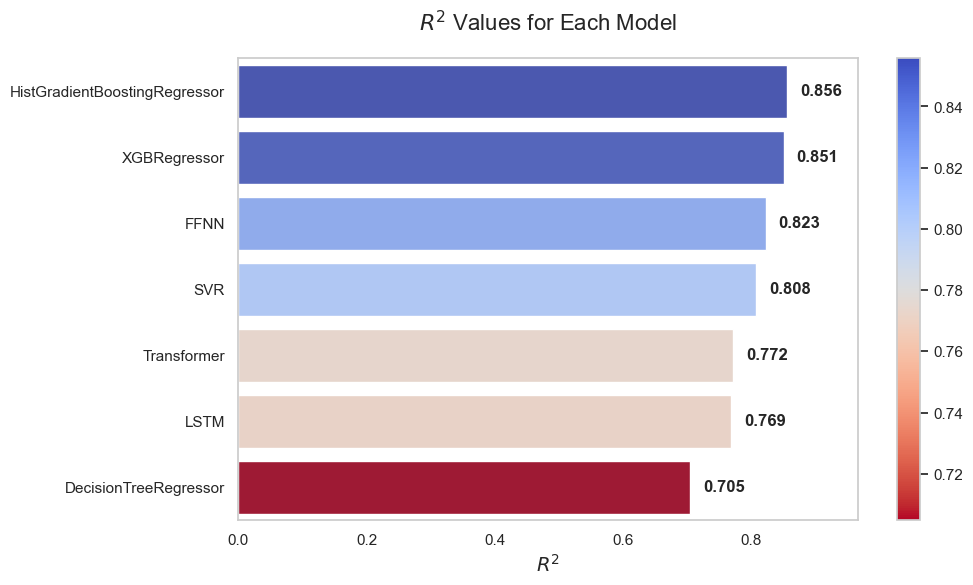

In [7]:
plt.rcdefaults()

data = pd.DataFrame({
    'Model': models,
    'R^2 Value': r2s
}).sort_values(by='R^2 Value', ascending=False)

norm = plt.Normalize(data['R^2 Value'].min(), data['R^2 Value'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm)
colors = sm.to_rgba(data['R^2 Value'])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='R^2 Value', y='Model', data=data, palette=colors)

for index, value in enumerate(data['R^2 Value']):
    ax.text(value + 0.02, index, f"{value:.3f}", va='center', fontsize=12, fontweight='bold')

plt.title(r'$R^2$ Values for Each Model', fontsize=16, pad=20)
plt.xlabel(r'$R^2$', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.xlim(0, data['R^2 Value'].max() + data['R^2 Value'].max()*0.13)

ax.grid(False) 
plt.colorbar(sm, ax=ax)  

plt.show()


# KÖR 3

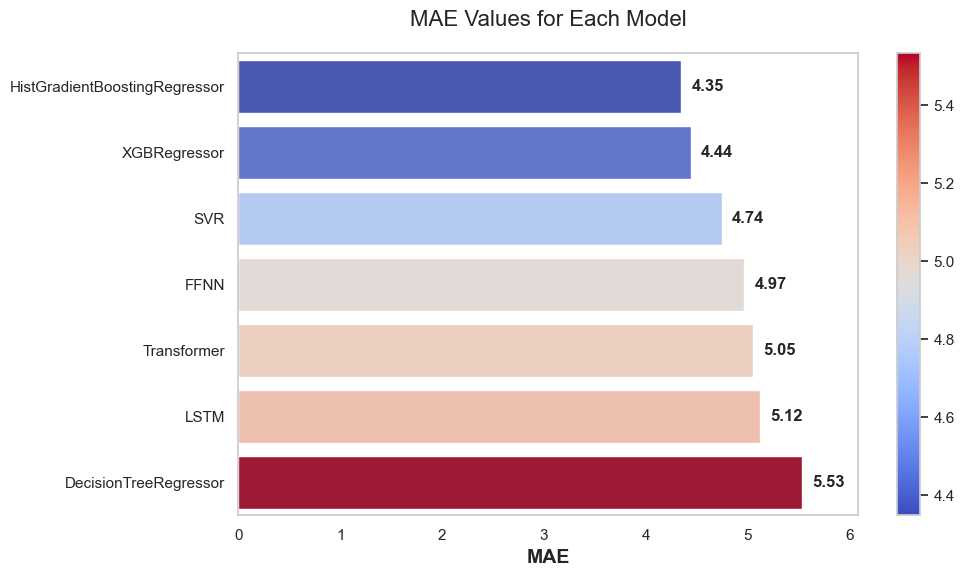

In [8]:
plt.rcdefaults()

data = pd.DataFrame({
    'Model': models,
    'MAE Value': maes
}).sort_values(by='MAE Value', ascending=True)

norm = plt.Normalize(data['MAE Value'].min(), data['MAE Value'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
colors = sm.to_rgba(data['MAE Value'])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='MAE Value', y='Model', data=data, palette=colors)

for index, value in enumerate(data['MAE Value']):
    ax.text(value + 0.1, index, f"{value:.2f}", va='center', fontsize=12, fontweight='bold')

plt.title(r'MAE Values for Each Model', fontsize=16, pad=20)
plt.xlabel(r'MAE', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.xlim(0, data['MAE Value'].max() + data['MAE Value'].max()*0.10)

ax.grid(False) 
plt.colorbar(sm, ax=ax)  

plt.show()

# KÖR 4

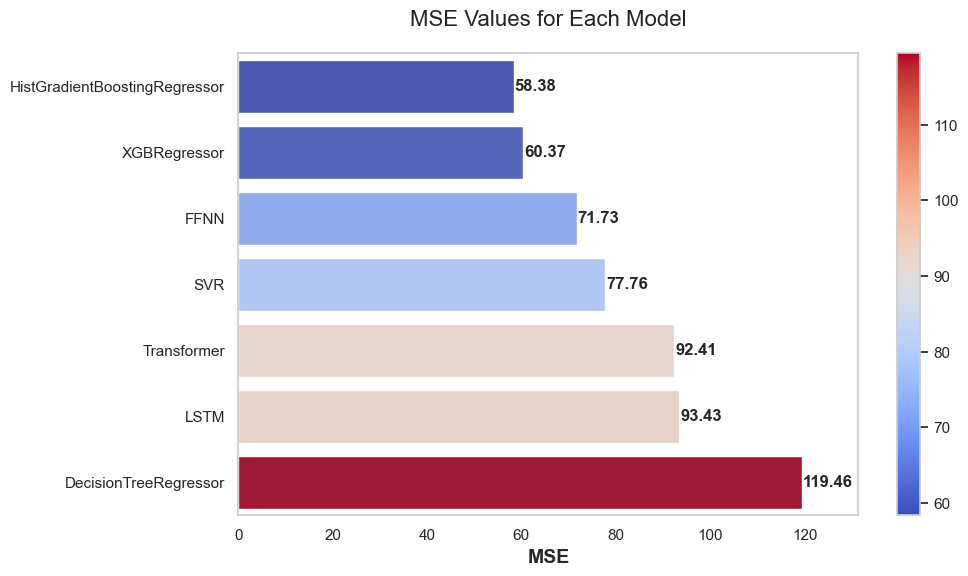

In [9]:
plt.rcdefaults()

data = pd.DataFrame({
    'Model': models,
    'MSE Value': mses
}).sort_values(by='MSE Value', ascending=True)

norm = plt.Normalize(data['MSE Value'].min(), data['MSE Value'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
colors = sm.to_rgba(data['MSE Value'])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='MSE Value', y='Model', data=data, palette=colors)

for index, value in enumerate(data['MSE Value']):
    ax.text(value + 0.2, index, f"{value:.2f}", va='center', fontsize=12, fontweight='bold')

plt.title(r'MSE Values for Each Model', fontsize=16, pad=20)
plt.xlabel(r'MSE', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.xlim(0, data['MSE Value'].max() + data['MSE Value'].max()*0.10)

ax.grid(False) 
plt.colorbar(sm, ax=ax)  

plt.show()

# KÖR 4

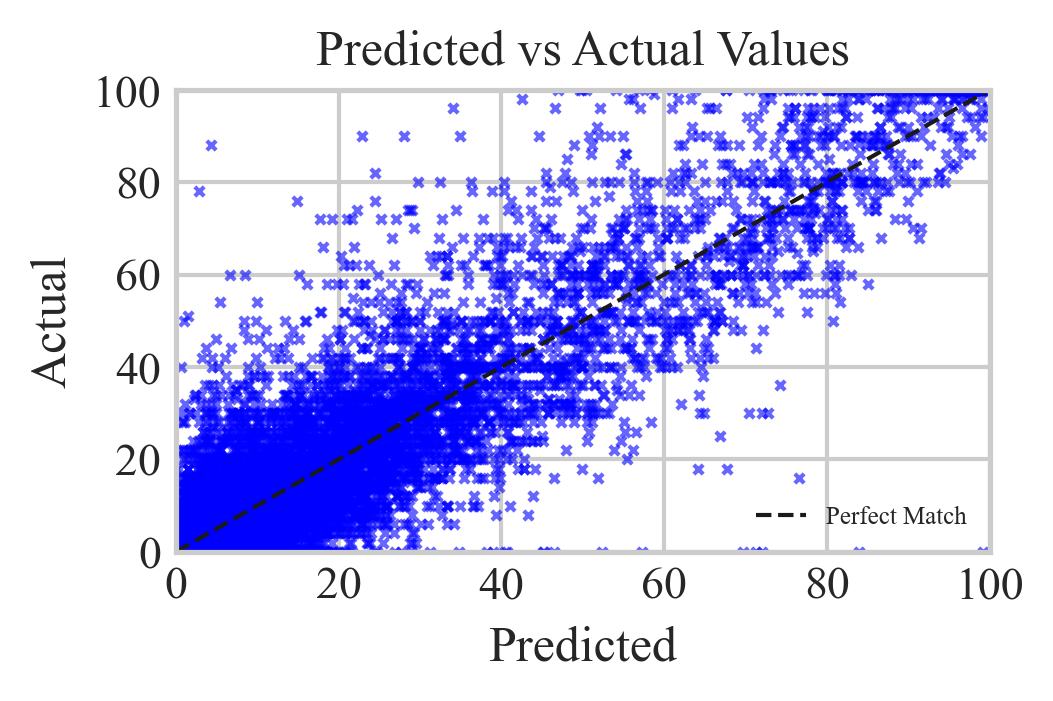

In [ ]:
data = pd.DataFrame({
    'Model': models,
    'R^2 Value': r2s
}).sort_values(by='R^2 Value', ascending=False)

best_model = data.iloc[0]  
best_model_name = best_model['Model']

if best_model_name == 'DecisionTreeRegressor':
    predictions = predictions_DecisionTreeRegressor
elif best_model_name == 'XGBRegressor':
    predictions = predictions_XGBRegressor
elif best_model_name == 'FFNN':
    predictions = predictions_FFNN
elif best_model_name == 'LSTM':
    predictions = predictions_LSTM
elif best_model_name == 'HistGradientBoostingRegressor':
    predictions = predictions_HistGradientBoostingRegressor
elif best_model_name == 'Transformer':
    predictions = predictions_Transformer

plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

actual_color = 'black'
pred_color = 'blue'
markersize = 5
marker_type = 'x' 

plt.figure(figsize=(2, 2))   
plt.title('Predicted vs Actual Values')
plt.scatter(predictions, actuals, alpha=0.6, color=pred_color, marker=marker_type, s=markersize, zorder=2, lw=1)  
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.ylim([0, 100])
plt.xlim([0, 100])
plt.plot([0, 100], [0, 100], color='k', linestyle='--', lw=1, zorder=2, label='Perfect Match')
plt.legend(frameon=False, fontsize=6, loc='lower right') 

plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')

plt.savefig('best_model_scatter.png')
plt.show()

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance

rows=16984
batch_size=32

folder = 'cumulative'
X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv')
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv')

feature_names = X_train.columns

X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

X_combined = np.vstack((X_train, X_test))
y_combined = np.concatenate((y_train, y_test))

combined_df = pd.DataFrame(X_combined, columns=feature_names)
combined_df['Target'] = y_combined

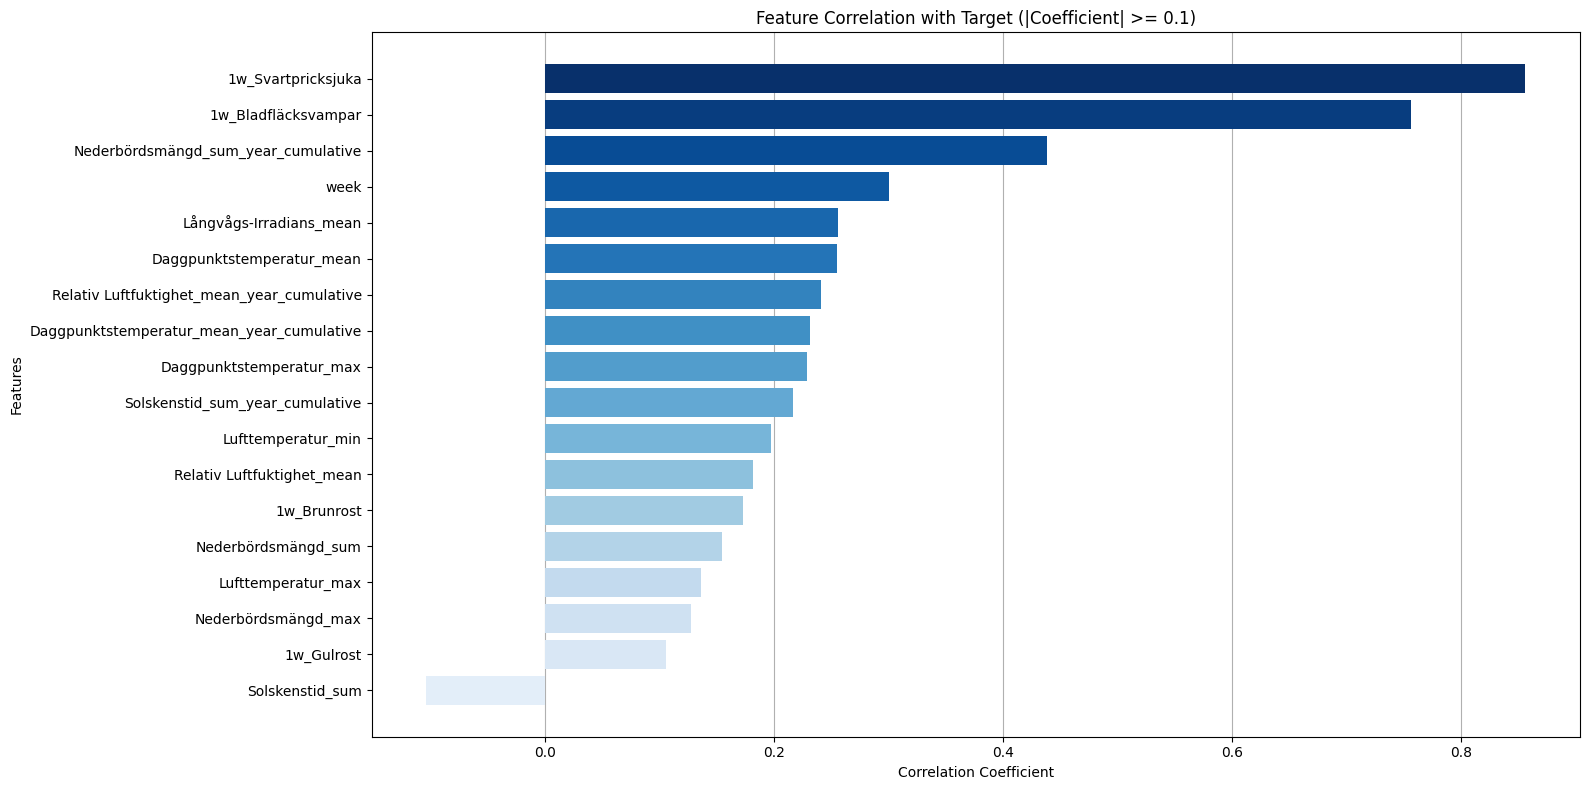

In [169]:
# 1. Correlation Analysis
correlation_matrix = combined_df.corr()
target_correlation = correlation_matrix['Target'].drop('Target')

coef_eps = 0.1
filtered_target_correlation = target_correlation[abs(target_correlation) >= coef_eps]
filtered_target_correlation_df = filtered_target_correlation.sort_values(ascending=True)

colors = plt.cm.Blues(np.linspace(0.1, 1, len(filtered_target_correlation_df)))

plt.figure(figsize=(16, 8))
plt.barh(filtered_target_correlation_df.index, filtered_target_correlation_df.values, color=colors, zorder=2)
plt.title(f'Feature Correlation with Target (|Coefficient| >= {coef_eps})')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x', ls='-', zorder=1)
plt.tight_layout()  
plt.show()


# Disease Severity by Year

Possible targets ['Bladfläcksvampar', 'Brunrost', 'Svartpricksjuka', 'Gulrost', 'Mjöldagg', 'Vetets bladfläcksjuka', 'Gräsbladlus', 'Sädesbladlus', 'Havrebladlus', 'Nederbörd']
week
15    20.000000
16    25.109589
17    13.154485
18     9.108153
19     4.918405
20     2.405242
21     1.052751
22     0.261000
23     0.597852
24     1.428289
25     6.695096
26    13.794851
27    17.865900
28    21.244275
Name: 2016, dtype: float64


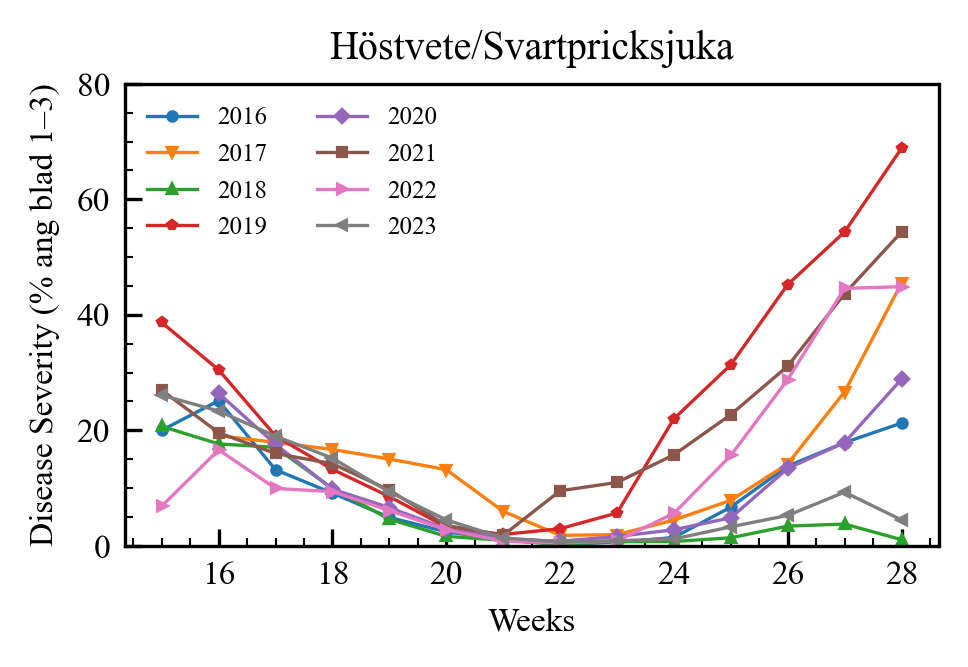

In [35]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datamodule import datamodule
 
plt.rcdefaults()

plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300})
matplotlib.rcParams['font.size'] = 8  
 
dm = datamodule(datamodule.HOSTVETE)
data_gdf = dm.data_gdf
 
data = data_gdf[['week', 'year', 'Svartpricksjuka']]
data = data.groupby(['week', 'year']).mean().reset_index()
data = data.pivot(index='week', columns='year', values='Svartpricksjuka')
 
print(data[2016])
 
actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5
 
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
markers = ['o', 'v', '^', 'p', 'D', 's', '>', '<']
colors = plt.get_cmap("tab10").colors[:len(years)]
 
plt.figure(figsize=(3.5, 2))
for year, marker, color in zip(years, markers, colors):
    plt.plot(data[year], color=color, lw=lw_actual, ls='-' ,marker=marker, markersize=markersize, label=str(year))
 
plt.xlabel('Weeks')
plt.ylabel(f'Disease Severity (% ang blad 1–3)')
plt.title(f'Höstvete/Svartpricksjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, ncol=2, fontsize=6, loc='upper left')
plt.ylim([0, 80])
plt.show()